In [1]:
## load mesh data with libigl
import numpy as np
import igl

## filediaglog, GL window
import tkinter
import tkinter.filedialog

## load XY-UV mesh
filename = 'data/long_sleeve1.obj'

if False:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.obj')]
    filename=tkinter.filedialog.askopenfilename(filetypes=fTyp, initialdir='./data', title='Open mesh file')
    root.destroy() ## [CAUTION]

x_full, u_full, _, tri_full, _, _ = igl.read_obj(filename)
x_full = x_full[:,:2] ## reduce vertex dimension: 3D -> 2D

In [2]:
## separate mesh
tri_subs = igl.extract_manifold_patches(tri_full)

## compute vertex to face correspondence in advance
v2f = igl.vertex_triangle_adjacency(tri_full, len(x_full))

selected = set(range(tri_subs[0])) ## select "all" as default
#selected = set()                   ## select "none" as default

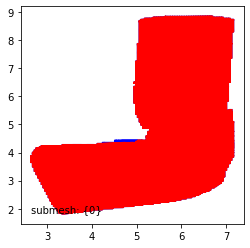

In [3]:
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(1, 1, figsize=(4,4))

line, = ax0.plot(x_full[:,0], x_full[:,1], c='b', picker=True, pickradius=1)
text = ax0.text(np.min(x_full[:,0]), np.min(x_full[:,1]), "submesh: ", va="bottom", ha="left")

## visualize the clicked submeshes
tri_sub  = tri_full[np.logical_or.reduce(np.array([tri_subs[1]==x for x in list(selected)]))]
vidx_sub = np.unique(tri_sub.reshape(-1))
x = x_full[vidx_sub]
ax0.plot(x[:,0], x[:,1], c='r')

text.set_text('submesh: {0}'.format(selected)) ## show as text

############################################################
## select submesh
############################################################
if False:
    def onpick(event):
        global selected

        if event.artist!=line: return True
        if not len(event.ind): return True

        ax0.plot(x_full[:,0], x_full[:,1], c='b')

        ## get the clicked point
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind

        ## get the submesh id
        clicked = tri_subs[1][v2f[0][v2f[1][ind[0]]]]
        
        if {clicked}.issubset(selected):
            selected.remove(clicked)
        else:
            selected.add(clicked)
        
        text.set_text('submesh: {}'.format(selected)) ## show as text

        ## visualize the clicked submeshes
        tri_sub  = tri_full[np.logical_or.reduce(np.array([tri_subs[1]==x for x in list(selected)]))]
        vidx_sub = np.unique(tri_sub.reshape(-1))
        x = x_full[vidx_sub]
        ax0.plot(x[:,0], x[:,1], c='r')
        
        return True
    
    fig.canvas.mpl_connect('pick_event', onpick)
    
else:
    text.set_text('submesh: {0}'.format(selected)) ## show as text

    ## visualize the default submesh
    tri_sub  = tri_full[tri_subs[1]==selected]
    vidx_sub = np.unique(tri_sub.reshape(-1))
    x = x_full[vidx_sub]
    ax0.plot(x[:,0], x[:,1], c='r')
    
plt.show()

In [4]:
## select the specific index from user-clicking point
tri_sub = tri_full[np.logical_or.reduce(np.array([tri_subs[1]==x for x in list(selected)]))]
#tri_sub = tri_full ## [TEMPORARY]

## separate submesh from full mesh
vidx_sub = np.unique(tri_sub.reshape(-1))
x = x_full[vidx_sub]
u = u_full[vidx_sub]

## convert vertex indices for submesh
N = x.shape[0]
vidx = np.arange(0, x.shape[0])

vidx_full_to_sub = {}
for a,b in zip(vidx_sub, vidx):
    vidx_full_to_sub[a] = b

tri = [np.array([vidx_full_to_sub[v0],
                 vidx_full_to_sub[v1],
                 vidx_full_to_sub[v2]])
       for v0, v1, v2 in tri_sub]

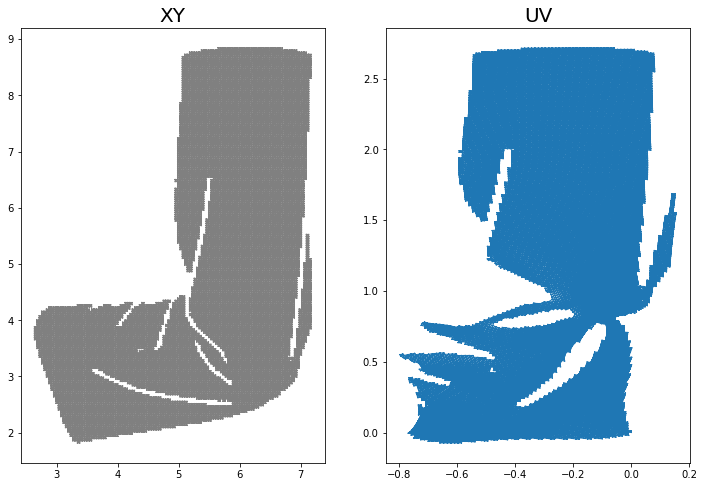

In [5]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

## XY-space (as gray)
ax1.set_title('XY').set_fontsize(20)
ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, c='gray')

if False:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

## UV-space (as blue)
ax2.set_title('UV').set_fontsize(20)
ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

if False:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

In [6]:
from datetime import datetime

start = datetime.now()

## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

## small spacing for embedding vertices
eps = 5e-2

u_min = u_min - eps
u_max = u_max + eps
v_min = v_min - eps
v_max = v_max + eps

########################################
## compute visualization range
## suppose: vertical > horizontal
########################################
percentile = 0.05
aspect = (u_max-u_min) / (v_max-v_min)

## uv
eps = percentile * (v_max-v_min)
v_min_vis = v_min - eps
v_max_vis = v_max + eps
u_min_vis = (u_max+u_min)*0.5 - (v_max_vis-v_min_vis)*0.5
u_max_vis = (u_max+u_min)*0.5 + (v_max_vis-v_min_vis)*0.5

if aspect > 1.0:
    eps = percentile * (u_max-u_min)
    u_min_vis = u_min - eps
    u_max_vis = u_max + eps
    v_min_vis = (v_max+v_min)*0.5 - (u_max_vis-u_min_vis)*0.5
    v_max_vis = (v_max+v_min)*0.5 + (u_max_vis-u_min_vis)*0.5

end = datetime.now()

#print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))
    
#print(u_min, v_min, u_max, v_max)

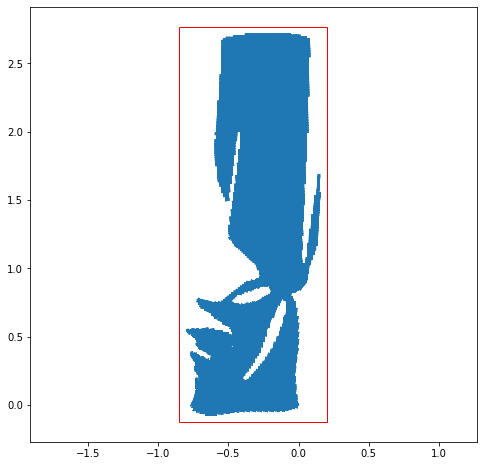

In [7]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])
ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

if False:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

<IPython.core.display.Javascript object>


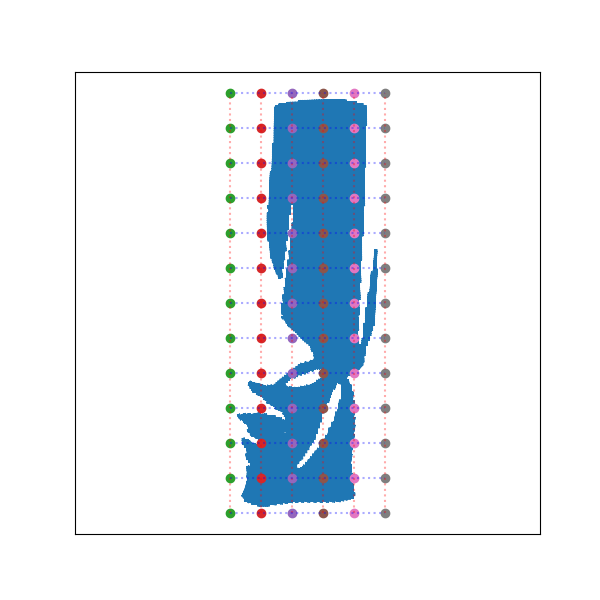

interactive(children=(IntSlider(value=6, description='subdiv_u', max=20, min=4), IntSlider(value=13, descripti…

In [8]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
%matplotlib notebook

## visualize bounding box
from matplotlib.patches import Rectangle

B_i = np.linspace(u_min, u_max, num=6)
B_j = np.linspace(v_min, v_max, num=8)

B_ix, B_jy = np.meshgrid(B_i, B_j)

#fig, ax = plt.subplots(figsize=(8,8))
fig, ax = plt.subplots(figsize=(6,6))

if True:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

@widgets.interact(subdiv_u = (4, 20, 1),
                  subdiv_v = (4, 20, 1))
def update(subdiv_u=6, subdiv_v=13):
    global B_i, B_j, B_ix, B_jy
    
    plt.cla()
    
    ## subdivide bounding box
    B_i = np.linspace(u_min, u_max, num=subdiv_u)
    B_j = np.linspace(v_min, v_max, num=subdiv_v)

    B_ix, B_jy = np.meshgrid(B_i, B_j)
    
    ax.set_xlim([u_min_vis, u_max_vis])
    ax.set_ylim([v_min_vis, v_max_vis])

    ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

    ## grid points
    ax.plot(B_ix, B_jy, 'o')

    ## draw lines between grid points
    for Bx in B_i:
        plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
    for By in B_j:
        plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

    #plt.draw()
    fig.canvas.draw()


In [9]:
## get the grid points B_{ij}
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2)

## revert u/v _ min/max for FFD
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

In [10]:
from InvFFD import invffd2d
from datetime import datetime

t0 = datetime.now()

B = np.dstack([B_ix, B_jy])
Bc_tilde_dok = invffd2d.ConstructBarycentricWeights(B, u, True)
Bc_tilde = Bc_tilde_dok.tocoo()

t1 = datetime.now()

L_tilde_dok = invffd2d.ConstructRegularizationTerm(B, len(u))
L_tilde = L_tilde_dok.tocoo()

t2 = datetime.now()

print("elapsed time: {0} [sec]".format( (t1-t0).total_seconds() ))
print("elapsed time: {0} [sec]".format( (t2-t1).total_seconds() ))

print("total elapsed time: {0} [sec]".format( (t2-t0).total_seconds() ))

elapsed time: 1.221456 [sec]
elapsed time: 0.0 [sec]
total elapsed time: 1.221456 [sec]


In [11]:
## constant part: make it as 1-dim vector + concat zero-vector
i = B_i.shape[0]
j = B_j.shape[0]
x_tilde = np.concatenate([x.reshape(-1), np.zeros([2*( (i-2)*j + i*(j-2) )])])

In [12]:
weight_lambda = 4.0
B_tilde = Bc_tilde + weight_lambda * L_tilde

In [37]:
## solve Least-Squares problem
from datetime import datetime
from scipy.sparse.linalg import lsqr, lsmr
from scipy.linalg import lstsq

print("try to solve least squares problem ...")

start = datetime.now()

## [SPEED ISSUE] convert to COO/CSC/CSR before solving it
#P_tilde, isstop, itn, r1norm = lsqr(B_tilde, x_tilde)[:4] ## use [Paige & Saunders, TOMS1982]
P_tilde, isstop, itn, r1norm = lsmr(B_tilde, x_tilde)[:4] ## use [Fong & Saunders, SISC2011] better than lsqr
#P_tilde, isstop, itn, r1norm = lstsq(B_tilde.todense(), x_tilde)[:4]

end = datetime.now()

print(isstop, itn)
print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

try to solve least squares problem ...
2 57
elapsed time: 0.100736 [sec]


In [38]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

In [39]:
## xy
#'''
x_min, x_max = np.min(P[:,0]), np.max(P[:,0])
y_min, y_max = np.min(P[:,1]), np.max(P[:,1])

eps = percentile * (y_max-y_min)
y_min_vis = y_min - eps
y_max_vis = y_max + eps
x_min_vis = (x_max+x_min)*0.5 - (y_max_vis-y_min_vis)*0.5
x_max_vis = (x_max+x_min)*0.5 + (y_max_vis-y_min_vis)*0.5

aspect = (x_max-x_min) / (y_max-y_min)

if aspect > 1.0:
    eps = percentile * (x_max-x_min)
    x_min_vis = x_min - eps
    x_max_vis = x_max + eps
    y_min_vis = (y_max+y_min)*0.5 - (x_max_vis-x_min_vis)*0.5
    y_max_vis = (y_max+y_min)*0.5 + (x_max_vis-x_min_vis)*0.5

#print(x_min, y_min, x_max, y_max)
#'''

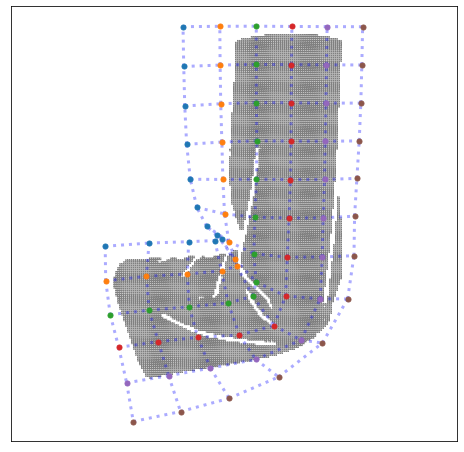

In [40]:
%matplotlib inline

## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])
#ax.set_xlim([3.75,5.75])
#ax.set_ylim([3.5,5.5])

ax.triplot(x[:,0], x[:,1], tri, linewidth=0.5, c='gray')

## grid points

#ax.plot(P_ix2, P_jy2, 'X', markersize=10, label='full')
#ax.plot(P_ix2[6:10,2:].reshape(-1), P_jy2[6:10,2:].reshape(-1), 'X', markersize=10, label='full')

if True:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title('XY')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

#ax.plot(x[4500,0], x[4500,1], 'o', c='black', markersize=10)

## draw lines
'''
for j in range(P_ix2.shape[0]):
    for i in range(P_ix2.shape[1]-1):
        plt.plot([P_ix2[j,i], P_ix2[j,i+1]], [P_jy2[j,i], P_jy2[j,i+1]], color='red', alpha=.33, linestyle=':', linewidth=3.0)

for i in range(P_ix2.shape[1]):
    for j in range(P_ix2.shape[0]-1):
        plt.plot([P_ix2[j,i], P_ix2[j+1,i]], [P_jy2[j,i], P_jy2[j+1,i]], color='red', alpha=.33, linestyle=':', linewidth=3.0)
'''

ax.plot(P_ix, P_jy, 'o', markersize=5, label='simple')
#ax.plot(P_ix[7:9,3:5].reshape(-1), P_jy[7:9,3:5].reshape(-1), 'o', markersize=5, label='simple')

#ax.legend()

## save as image
if False:
    plt.subplots_adjust(left=-0.00025, right=0.9985, top=1.0, bottom=0.0012) ## really tight margin
    plt.savefig("test.png")

plt.show()

In [41]:
## gridmesh vertices
grid_X = B_ix.shape[1]*4
grid_Y = B_ix.shape[0]*4
new_u_ix, new_u_jy = np.meshgrid(np.linspace(u_min, u_max, grid_X),
                                 np.linspace(v_min, v_max, grid_Y))
new_u = np.dstack((new_u_ix, new_u_jy)).reshape(-1,2)
#print(new_u_ij.shape)

## simple triangulation for gridmesh
new_tri = []
for j in range(grid_Y-1):
    for i in range(grid_X-1):
        f00 = (i+0) + grid_X*(j+0)
        f01 = (i+1) + grid_X*(j+0)
        f10 = (i+0) + grid_X*(j+1)
        f11 = (i+1) + grid_X*(j+1)
        new_tri.append([f00, f01, f10])
        new_tri.append([f10, f01, f11])

new_tri = np.array(new_tri)

if False:
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xlim([u_min_vis, u_max_vis])
    ax.set_ylim([v_min_vis, v_max_vis])
    ax.triplot(new_u[:,0], new_u[:,1], new_tri, linewidth=1, color='green')
    #ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

    plt.show()

In [42]:
if False:
    P_ix = np.load("./data/long_sleeve1_P_ix_6x13.npy")
    P_jy = np.load("./data/long_sleeve1_P_jy_6x13.npy")

In [43]:
from InvFFD import ffd2d

new_ind, new_ST = ffd2d.FFD_precompute(B, new_u)

P = np.dstack([P_ix, P_jy])
new_x = ffd2d.FFD(new_ind, new_ST, P)

In [44]:
def RecomputeFFD_Partial(id_i, id_j):
    global new_x
    
    ## masking the partial array for fast computation
    recompute = np.array([(id_i-2 <= i and i <= id_i+1 and
                           id_j-2 <= j and j <= id_j+1    ) for (i,j) in new_ind])
    new_ind_partial = new_ind[recompute]
    new_ST_partial  = new_ST [recompute]
    
    P = np.dstack([P_ix, P_jy])
    new_x_partial = ffd2d.FFD(new_ind_partial, new_ST_partial, P)
    
    ## re-append to the original array
    indices = np.where(recompute)
    new_x[indices] = new_x_partial

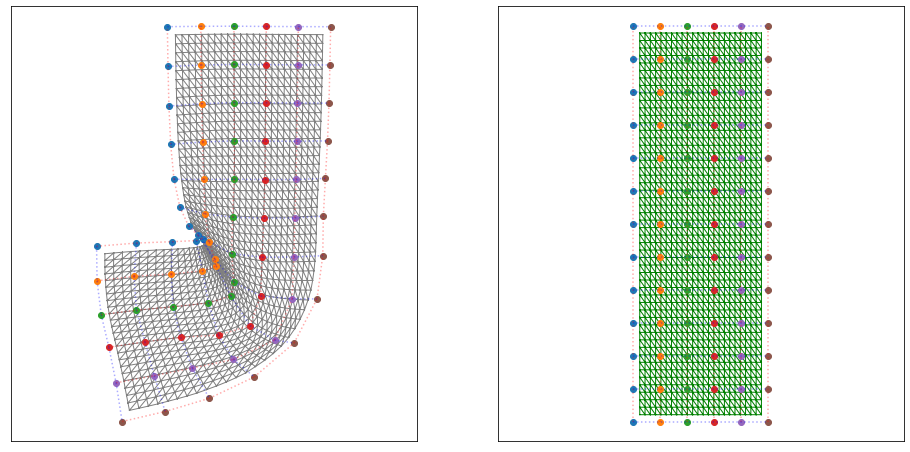

In [45]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

########################################
## Transferred by Forward FFD
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(new_x[:,0], new_x[:,1], new_tri, linewidth=1, color='gray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
#"""
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')
#"""

#ax1.set_title('xy').set_fontsize(20)

if True:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

########################################
## original mesh (for comparison)
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(new_u[:,0], new_u[:,1], new_tri, linewidth=1, color='green')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

#ax2.set_title('uv').set_fontsize(20)

if True:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

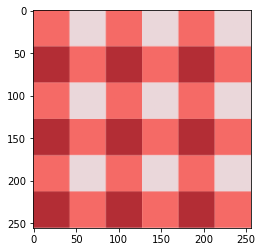

In [46]:
## read texture image
filename = 'data/long_sleeve1.png'

if False:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.png;*.jpg;*.bmp')]
    filename=tkinter.filedialog.askopenfilename(filetypes=fTyp, initialdir='./data')
    root.destroy() ## [CAUTION]

tex2D = plt.imread(filename) ## re-use matplotlib.pyplot
#tex2D = np.ones([256,256,4]).astype('float32') ## [TEMPORARY] make blank texture

plt.imshow(tex2D)

In [47]:
from OpenGL import GL

## get texture type
tex2D_type = GL.GL_RED

if tex2D.shape[2]==3: tex2D_type = GL.GL_RGB
if tex2D.shape[2]==4: tex2D_type = GL.GL_RGBA

def DrawTriMesh(x, tri, u=None):
    #GL.glEnable(GL.GL_TEXTURE_2D)
    GL.glEnableClientState(GL.GL_VERTEX_ARRAY)
    GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(x) )

    if u is None:
        GL.glDrawElements(GL.GL_TRIANGLES, len(np.ravel(tri)), GL.GL_UNSIGNED_INT, np.ravel(tri))
    else:
        if x.shape==u.shape and u.shape[1]==2:
            GL.glEnableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            GL.glTexCoordPointer(2, GL.GL_DOUBLE, 0, np.ravel(u) )
            GL.glDrawElements(GL.GL_TRIANGLES, len(np.ravel(tri)), GL.GL_UNSIGNED_INT, np.ravel(tri))
            GL.glDisableClientState(GL.GL_TEXTURE_COORD_ARRAY)

    GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
    #GL.glDisable(GL.GL_TEXTURE_2D)
    return None

def DrawGrid(P_ix, P_jy, boundary=False):
    assert P_ix.shape == P_jy.shape
    
    N = P_ix.shape[0]-1
    M = P_ix.shape[1]-1
    
    GL.glBegin(GL.GL_LINES)
    
    if boundary:
        for i in range(N):
            GL.glVertex2d(P_ix[i  ,0  ], P_jy[i  ,0  ])
            GL.glVertex2d(P_ix[i+1,0  ], P_jy[i+1,0  ])
            GL.glVertex2d(P_ix[i  ,M  ], P_jy[i  ,M  ])
            GL.glVertex2d(P_ix[i+1,M  ], P_jy[i+1,M  ])
            
        for j in range(M):
            GL.glVertex2d(P_ix[0  ,j  ], P_jy[0  ,j  ])
            GL.glVertex2d(P_ix[0  ,j+1], P_jy[0  ,j+1])
            GL.glVertex2d(P_ix[N  ,j  ], P_jy[N  ,j  ])
            GL.glVertex2d(P_ix[N  ,j+1], P_jy[N  ,j+1])
        
    else:
        for i in range(N):
            for j in range(M):
                GL.glVertex2d(P_ix[i  ,j  ], P_jy[i  ,j  ])
                GL.glVertex2d(P_ix[i  ,j+1], P_jy[i  ,j+1])
                GL.glVertex2d(P_ix[i  ,j  ], P_jy[i  ,j  ])
                GL.glVertex2d(P_ix[i+1,j  ], P_jy[i+1,j  ])
                GL.glVertex2d(P_ix[i+1,j  ], P_jy[i+1,j  ])
                GL.glVertex2d(P_ix[i+1,j+1], P_jy[i+1,j+1])
                GL.glVertex2d(P_ix[i  ,j+1], P_jy[i  ,j+1])
                GL.glVertex2d(P_ix[i+1,j+1], P_jy[i+1,j+1])
    
    GL.glEnd()
    
    return None

def DrawControlPoints(P_ix, P_jy, bullet=(8.0,4.0)):

    ## color cycyle in matplotlib: https://stackoverflow.com/a/42091037
    colorList = [( 31,119,180), (255,127, 14), ( 44,160, 44), (214, 39, 40), (148,103,189),
                 (140, 86, 75), (227,119,194), (127,127,127), (188,189, 34), ( 23,190,207)]

    ## black bullet for back
    GL.glPointSize(bullet[0])
    GL.glColor3d(0.0, 0.0, 0.0)
    
    GL.glBegin(GL.GL_POINTS)
    for j in range(P_ix.shape[1]):
        for i in range(P_ix.shape[0]):
            GL.glVertex3d(P_ix[i,j], P_jy[i,j], 0.0)
    GL.glEnd()

    ## colored bullet
    GL.glPointSize(bullet[1])
    
    GL.glBegin(GL.GL_POINTS)
    for j in range(P_ix.shape[1]):
        GL.glColor3d(colorList[j][0] / 255.0, colorList[j][1] / 255.0, colorList[j][2] / 255.0)
        for i in range(P_ix.shape[0]):
            GL.glVertex2d(P_ix[i,j], P_jy[i,j])
    GL.glEnd()

    return None

edge = igl.exterior_edges(np.array(tri))

def DrawBoundaryTriMeshBoudnary(x):
    GL.glBegin(GL.GL_LINES)
    for e0,e1 in edge:
        GL.glVertex2d(x[e0,0], x[e0,1])
        GL.glVertex2d(x[e1,0], x[e1,1])
    GL.glEnd()
    
    return None


In [ ]:
from pyopengltk import OpenGLFrame

###############################################################################
## keyboard interaction
###############################################################################
with_stencil = False
show_grid = False
show_wire = False
show_wire_original = True
show_gridmesh = False

def key_press(event):
    #print(event, end='\r')
    global with_stencil, show_wire, show_gridmesh, show_wire_original, show_grid
    
    if event.keysym=='s' or event.keysym=='S':
        with_stencil = False if with_stencil else True
        
    if event.keysym=='e' or event.keysym=='E':
        show_wire = False if show_wire else True

    if event.keysym=='g' or event.keysym=='G':
        show_grid = False if show_grid else True
        
    if event.keysym=='w' or event.keysym=='W':
        show_wire_original = False if show_wire_original else True

    if event.keysym=='t' or event.keysym=='T':
        show_gridmesh = False if show_gridmesh else True
        
class AppGL(OpenGLFrame):

    def initgl(self):
        GL.glClearColor(0.2, 0.3, 0.5, 0.0) ## skyblue
        #GL.glClearColor(0.0, 0.0, 0.0, 0.0) ## black
        #GL.glClearColor(0.25, 0.25, 0.25, 0.0) ## darkgray
        
        ########################################
        ## texture creation
        ########################################
        self.texture = GL.glGenTextures(1)
        
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_S, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_T, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MIN_FILTER, GL.GL_LINEAR)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MAG_FILTER, GL.GL_LINEAR)
        
        GL.glTexImage2D(GL.GL_TEXTURE_2D, 0, tex2D_type, 
                        tex2D.shape[1], tex2D.shape[0], 0, tex2D_type, GL.GL_FLOAT, np.ravel(tex2D))
        
    def redraw(self):
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        
        ## set projection matrix: orthogonal camera
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GL.glOrtho(x_min_vis, x_max_vis, y_min_vis, y_max_vis, -1.0, 1.0)
        
        ## set camera position as identity
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        
        GL.glLineWidth(1.0)
        
        ## set stencil for rendering
        if with_stencil:
            GL.glEnable(GL.GL_STENCIL_TEST)
            GL.glStencilFunc(GL.GL_ALWAYS, 1, 0xFF)
            GL.glStencilOp(GL.GL_KEEP, GL.GL_KEEP, GL.GL_REPLACE)
            GL.glStencilMask(0xFF)
            GL.glDepthMask(GL.GL_FALSE)
            GL.glClear(GL.GL_STENCIL_BUFFER_BIT)
        
        GL.glDisable(GL.GL_TEXTURE_2D)
        
        ## original mesh (fill)
        if True:
            GL.glColor3d(1.0, 1.0, 1.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawTriMesh(x, tri, u)
        
        if with_stencil:
            GL.glStencilFunc(GL.GL_EQUAL, 1, 0xFF)
            GL.glStencilMask(0x00)
            GL.glDepthMask(GL.GL_TRUE)
        
        GL.glEnable(GL.GL_TEXTURE_2D)
        
        ## FFD gridmesh (fill)
        if show_gridmesh:
            GL.glColor3d(1.0, 1.0, 1.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawTriMesh(new_x, new_tri, new_u)
            
        ## FFD gridmesh (line)
        if show_wire:
            GL.glColor3d(0.0, 0.0, 0.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(new_x, new_tri)
        
        GL.glDisable(GL.GL_STENCIL_TEST)
        
        GL.glDisable(GL.GL_TEXTURE_2D)
        
        ## original mesh (line)
        GL.glColor3d(0.0, 0.0, 0.0)
        if show_wire_original:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(x, tri)
            
        ## original mesh boundary (line)
        if True:
            GL.glLineWidth(3.0)
            GL.glColor3d(0.0, 0.0, 0.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawBoundaryTriMeshBoudnary(x)
        
        ## draw lines between control points
        GL.glLineWidth(1.0)
        
        if show_grid==False: return None
        
        GL.glColor3d(0.0, 1.0, 0.0) ## green
        if True:
            DrawGrid(P_ix, P_jy)
            
        ## draw boundary outlines
        if True:
            GL.glLineWidth(5.0)
            DrawGrid(P_ix, P_jy, boundary=True)

        ## draw control points
        if True:
            DrawControlPoints(P_ix, P_jy, bullet=(8.0, 4.0))
        
###############################################################################
## window (similar to GLUT/GLFW)
###############################################################################
root = tkinter.Tk()

app = AppGL(root, width=800, height=800)
app.pack(fill=tkinter.BOTH, expand=tkinter.YES)
app.animate = 1


###############################################################################
## compute projected point & get the nearest point
###############################################################################
def get3D(win_x, win_y):
    x = win_x / root.winfo_width()
    y = (root.winfo_height()-win_y) / root.winfo_height() ## [CAUTION]
    
    x = x_min_vis + x * (x_max_vis - x_min_vis)
    y = y_min_vis + y * (y_max_vis - y_min_vis)
    return x, y

def getNearestControlPoint(x,y):
    min_dist = np.inf
    min_id = (-1,-1)
    
    for j in range(P_ix.shape[1]):
        for i in range(P_ix.shape[0]):
            dx = x - P_ix[i,j]
            dy = y - P_jy[i,j]
            dist = dx*dx + dy*dy
            
            if dist < min_dist:
                min_dist = dist
                min_id = (i,j)
            
    return np.sqrt(min_dist), min_id


###############################################################################
## mouse interaction
###############################################################################
drag = False
drag_id = (-1,-1)

def motion(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if drag:
        x, y = get3D(event.x, event.y)
        
        P_ix[drag_id[0],drag_id[1]] = x
        P_jy[drag_id[0],drag_id[1]] = y
        
        RecomputeFFD_Partial(drag_id[0], drag_id[1])
    
def press(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if event.num == 1:
        x, y = get3D(event.x, event.y)
        
        ## pick the nearest control point ...
        min_dist, min_id = getNearestControlPoint(x,y)
        
        if min_dist < 0.3:
            #print(min_dist, min_id)
            drag = True
            drag_id = min_id
    
def release(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if event.num == 1:
        drag = False
        drag_id = (-1,-1)


## register mouse callbacks to Tkinter window
root.bind('<Motion>', motion)
root.bind('<ButtonPress>', press)
root.bind('<ButtonRelease>', release)
root.bind('<KeyPress>', key_press)

## finally, run GL program
#app.after(100, app.printContext)
app.mainloop()

print('CLOSED')

In [ ]:
## save control points if needed
if False:
    np.save('./output/P_ix.npy', P_ix)
    np.save('./output/P_jy.npy', P_jy)

## Remap to original mesh

- get the mapped triangle its relative position to get new uv for each vertex x_ffd
- export mesh file (.obj) with material (.mtl) and texture image (.png)

In [ ]:
def triangleArea(v0, v1, v2):
    a = np.array([[v0[0], v0[1], 1.0],
                  [v1[0], v1[1], 1.0],
                  [v2[0], v2[1], 1.0]])
    return 0.5 * np.abs(np.linalg.det(a))

def lineDet(x1, y1, x2, y2, x, y):
    a = y2-y1
    b = x2-x1
    c = -a*x1 + b*y1
    
    return a*x - b*y + c >= 0

In [ ]:
#import scipy.spatial as ss
from scipy.spatial import KDTree

u_invffd = u.copy()

print("try to remap uv ...")

start = datetime.now()

## to use k-d tree !
tree = KDTree(new_x, leafsize=10)
v2f_grid = igl.vertex_triangle_adjacency(new_tri, len(new_x))

for k in range(len(u_invffd)):
    xk = x[k]
    
    errorneous = True
    _, vindices = tree.query(xk, 3) ## 6 is for safety
    
    for vidx in vindices:
        for what in range(v2f_grid[1][vidx], v2f_grid[1][vidx+1]):
            fidx = v2f_grid[0][what]
            
            ## get three vertices of this triangle
            v0 = new_x[new_tri[fidx][0]]
            v1 = new_x[new_tri[fidx][1]]
            v2 = new_x[new_tri[fidx][2]]
            
            ## check the ffd vertex is inside of this triangle:
            b_v0_v1 = lineDet(v1[0], v1[1], v0[0], v0[1], xk[0], xk[1])
            b_v1_v2 = lineDet(v2[0], v2[1], v1[0], v1[1], xk[0], xk[1])
            b_v2_v0 = lineDet(v0[0], v0[1], v2[0], v2[1], xk[0], xk[1])
            
            ## compute new uv based on the barycentric coordinate
            if (b_v0_v1 and b_v1_v2 and b_v2_v0):
                w  = triangleArea(v0, v1, v2)
                w0 = triangleArea(xk, v1, v2) / w
                w1 = triangleArea(v0, xk, v2) / w
                w2 = triangleArea(v0, v1, xk) / w
                u_invffd[k] = w0*new_u[new_tri[fidx][0]] + w1*new_u[new_tri[fidx][1]] + w2*new_u[new_tri[fidx][2]]
                errorneous = False
                break
    
    print("{0:4d} / {1:4d}".format(k, len(u_invffd)),end='\r')

    if errorneous:
        print("{0:4d} / {1:4d} - invalid mapping! check FFD grid...".format(k, len(u_invffd)),end='\n')

        ## visualize control points in X-space
        fig, ax = plt.subplots(figsize=(8,8))

        ax.set_xlim([x_min_vis,x_max_vis])
        ax.set_ylim([y_min_vis,y_max_vis])
        ax.triplot(x[:,0], x[:,1], tri, linewidth=0.5, c='gray')

        if True:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        ax.plot(x[k,0], x[k,1], 'o', color='red')

        plt.show()        
    
end = datetime.now()

print("{0:4d} / {0:4d} - DONE".format(len(u_invffd)))

print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

In [ ]:
import os.path

filename = 'output/modified.obj'

if True:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.obj')]
    filename = tkinter.filedialog.asksaveasfilename(filetypes=fTyp, title='Save mesh file', initialdir='./output', defaultextension="*.obj")
    root.destroy() ## [CAUTION]

## export the final mesh as obj file with uv values
with open(filename, 'w') as f:
    f.write('mtllib ' + os.path.splitext(os.path.basename(filename))[0]+'.mtl\n')

    for _v in x:
        f.write('v {0} {1} 0\n'.format(_v[0], _v[1]))
    
    for _vt in u_invffd:
        f.write('vt {0} {1}\n'.format(_vt[0], _vt[1]))

    for _tri in tri:
        f.write('f {0}/{0} {1}/{1} {2}/{2}\n'.format(_tri[0]+1, _tri[1]+1, _tri[2]+1))

## export material file
with open(os.path.splitext(filename)[0]+'.mtl', 'w') as f:
    f.write('map_Kd ' + os.path.splitext(os.path.basename(filename))[0]+'.png\n')

## export texture image
plt.imsave(os.path.splitext(filename)[0]+'.png', tex2D)

In [ ]:
def DrawQuad(x, u):
    assert x.shape==u.shape
    assert x.shape==(4,2)

    GL.glEnable(GL.GL_TEXTURE_2D)
    GL.glBegin(GL.GL_QUADS)

    GL.glTexCoord2d(u[0,0], u[0,1])
    GL.glVertex2d  (x[0,0], x[0,1])
    GL.glTexCoord2d(u[1,0], u[1,1])
    GL.glVertex2d  (x[1,0], x[1,1])
    GL.glTexCoord2d(u[2,0], u[2,1])
    GL.glVertex2d  (x[2,0], x[2,1])
    GL.glTexCoord2d(u[3,0], u[3,1])
    GL.glVertex2d  (x[3,0], x[3,1])
    
    GL.glEnd()
    GL.glDisable(GL.GL_TEXTURE_2D)
    
    return None

uv_minmax = np.array([[u_min_vis, v_max_vis],
                      [u_min_vis, v_min_vis],
                      [u_max_vis, v_min_vis],
                      [u_max_vis, v_max_vis] ])

N = B_ix.shape[0] - 1
M = B_ix.shape[1] - 1
B_minmax = np.array([[B_ix[0,0], B_jy[0,0]],
                     [B_ix[0,M], B_jy[0,M]],
                     [B_ix[N,M], B_jy[N,M]],
                     [B_ix[N,0], B_jy[N,0]] ])

class AppGL2(OpenGLFrame):

    def initgl(self):
        GL.glClearColor(0.5, 0.5, 0.5, 0.0) ## gray
        #GL.glClearColor(1.0, 1.0, 1.0, 0.0) ## white
        
        ########################################
        ## texture creation
        ########################################
        self.texture = GL.glGenTextures(1)
        
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_S, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_T, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MIN_FILTER, GL.GL_LINEAR)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MAG_FILTER, GL.GL_LINEAR)
        
        GL.glTexImage2D(GL.GL_TEXTURE_2D, 0, tex2D_type, 
                        tex2D.shape[1], tex2D.shape[0], 0, tex2D_type, GL.GL_FLOAT, np.ravel(tex2D))
        
    def redraw(self):
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        
        ## set projection matrix: orthogonal camera
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GL.glOrtho(u_min_vis, u_max_vis, v_min_vis, v_max_vis, -1.0, 1.0)

        ## set camera position as identity
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        
        ## background quad UV
        #GL.glColor3d(1.0, 1.0, 1.0)
        GL.glColor3d(0.25, 0.25, 0.25)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawQuad(uv_minmax, uv_minmax)
            
        ## quad UV
        if False:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawQuad(B_minmax, B_minmax)
            
        ## remapped mesh (fill)
        GL.glColor3d(1.0, 1.0, 1.0)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawTriMesh(u_invffd, tri, u_invffd)

        ## remapped mesh (line)
        GL.glLineWidth(0.5)
        if False:
            #GL.glColor3d(0.0, 0.0, 0.0) # black
            GL.glColor3d(0.25, 0.25, 0.25) # darkgray
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(u_invffd, tri)
        
        ## FFD gridmesh (fill)
        if False:
            GL.glColor3d(1.0, 1.0, 1.0)
            #GL.glColor3d(0.5, 0.5, 0.5)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawTriMesh(new_u, new_tri, new_u)
            
        ## FFD gridmesh (line)
        if False:
            GL.glColor3d(0.0, 0.0, 0.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(new_u, new_tri)
            
        ## draw exterior edge (u)
        GL.glLineWidth(3.0)
        
        ## original mesh boundary (line)
        if True:
            GL.glColor3d(0.0, 1.0, 1.0) ## cyan
            DrawBoundaryTriMeshBoudnary(u)
        
        ## remapped mesh boundary (line)
        if True:
            GL.glColor3d(1.0, 0.0, 0.0) ## red
            DrawBoundaryTriMeshBoudnary(u_invffd)
        
        ## draw lines between control points
        GL.glColor3d(0.0, 1.0, 0.0) ## green
        if True:
            GL.glLineWidth(1.0)
            DrawGrid(B_ix, B_jy)

        ## draw boundary outlines
        if True:
            GL.glLineWidth(4.0)
            DrawGrid(B_ix, B_jy, boundary=True)
        
        ## draw control points
        if True:
            DrawControlPoints(B_ix, B_jy, bullet=(8.0, 4.0))

###############################################################################
## window (similar to GLUT/GLFW)
###############################################################################
root = tkinter.Tk()

app = AppGL2(root, width=800, height=800)
app.pack(fill=tkinter.BOTH, expand=tkinter.YES)
app.animate = 1

## finally, run GL program
#app.after(100, app.printContext) 
app.mainloop()

print('CLOSED')

In [ ]:
def DrawQuad(x, u):
    assert x.shape==u.shape
    assert x.shape==(4,2)

    GL.glEnable(GL.GL_TEXTURE_2D)
    GL.glBegin(GL.GL_QUADS)

    GL.glTexCoord2d(u[0,0], u[0,1])
    GL.glVertex2d  (x[0,0], x[0,1])
    GL.glTexCoord2d(u[1,0], u[1,1])
    GL.glVertex2d  (x[1,0], x[1,1])
    GL.glTexCoord2d(u[2,0], u[2,1])
    GL.glVertex2d  (x[2,0], x[2,1])
    GL.glTexCoord2d(u[3,0], u[3,1])
    GL.glVertex2d  (x[3,0], x[3,1])
    
    GL.glEnd()
    GL.glDisable(GL.GL_TEXTURE_2D)
    
    return None

uv_minmax = np.array([[u_min_vis, v_max_vis],
                      [u_min_vis, v_min_vis],
                      [u_max_vis, v_min_vis],
                      [u_max_vis, v_max_vis] ])

N = B_ix.shape[0] - 1
M = B_ix.shape[1] - 1
B_minmax = np.array([[B_ix[0,0], B_jy[0,0]],
                     [B_ix[0,M], B_jy[0,M]],
                     [B_ix[N,M], B_jy[N,M]],
                     [B_ix[N,0], B_jy[N,0]] ])

class AppGL2(OpenGLFrame):

    def initgl(self):
        GL.glClearColor(0.5, 0.5, 0.5, 0.0) ## gray
        #GL.glClearColor(1.0, 1.0, 1.0, 0.0) ## white
        
        ########################################
        ## texture creation
        ########################################
        self.texture = GL.glGenTextures(1)
        
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_S, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_T, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MIN_FILTER, GL.GL_LINEAR)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MAG_FILTER, GL.GL_LINEAR)
        
        GL.glTexImage2D(GL.GL_TEXTURE_2D, 0, tex2D_type, 
                        tex2D.shape[1], tex2D.shape[0], 0, tex2D_type, GL.GL_FLOAT, np.ravel(tex2D))
        
    def redraw(self):
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        
        ## set projection matrix: orthogonal camera
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GL.glOrtho(u_min_vis, u_max_vis, v_min_vis, v_max_vis, -1.0, 1.0)

        ## set camera position as identity
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        
        ## background quad UV
        #GL.glColor3d(1.0, 1.0, 1.0)
        GL.glColor3d(0.25, 0.25, 0.25)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawQuad(uv_minmax, uv_minmax)
            
        ## quad UV
        if False:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawQuad(B_minmax, B_minmax)

        GL.glEnable(GL.GL_TEXTURE_2D)

        ## remapped mesh (fill)
        GL.glColor3d(1.0, 1.0, 1.0)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            #DrawTriMesh(u_invffd, tri, u_invffd)
            DrawTriMesh(u, tri, u)

        ## remapped mesh (line)
        GL.glLineWidth(0.5)
        if False:
            #GL.glColor3d(0.0, 0.0, 0.0) # black
            GL.glColor3d(0.25, 0.25, 0.25) # darkgray
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(u_invffd, tri)
        
        ## FFD gridmesh (fill)
        if True:
            GL.glColor3d(1.0, 1.0, 1.0)
            #GL.glColor3d(0.5, 0.5, 0.5)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            DrawTriMesh(new_u, new_tri, new_u)
            
        ## FFD gridmesh (line)
        if False:
            GL.glColor3d(0.0, 0.0, 0.0)
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            DrawTriMesh(new_u, new_tri)
        
        GL.glDisable(GL.GL_TEXTURE_2D)

        ## draw exterior edge (u)
        GL.glLineWidth(3.0)
        
        ## original mesh boundary (line)
        if True:
            GL.glColor3d(0.0, 1.0, 1.0) ## cyan
            DrawBoundaryTriMeshBoudnary(u)
        
        ## remapped mesh boundary (line)
        if False:
            GL.glColor3d(1.0, 0.0, 0.0) ## red
            DrawBoundaryTriMeshBoudnary(u_invffd)
        
        ## draw lines between control points
        GL.glColor3d(0.0, 1.0, 0.0) ## green
        if True:
            GL.glLineWidth(1.0)
            DrawGrid(B_ix, B_jy)

        ## draw boundary outlines
        if True:
            GL.glLineWidth(4.0)
            DrawGrid(B_ix, B_jy, boundary=True)
        
        ## draw control points
        if True:
            DrawControlPoints(B_ix, B_jy, bullet=(8.0, 4.0))

###############################################################################
## window (similar to GLUT/GLFW)
###############################################################################
root = tkinter.Tk()

app = AppGL2(root, width=800, height=800)
app.pack(fill=tkinter.BOTH, expand=tkinter.YES)
app.animate = 1

## finally, run GL program
#app.after(100, app.printContext) 
app.mainloop()

print('CLOSED')

(end)

In [ ]:
def GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x, y):
    ax =  x00 - x10 - x01 + x11
    ay =  y00 - y10 - y01 + y11
    bx = -x00 + x10
    by = -y00 + y10
    cx = -x00 + x01
    cy = -y00 + y01
    dx = -x00 + x
    dy = -y00 + y
    
    A1 = (ay*bx - ax*by)
    B1 = (ay*dx - ax*dy + by*cx - bx*cy)
    C1 = (cx*dy - cy*dx)
    
    A2 = (ay*cx - ax*cy)
    B2 = (ay*dx - ax*dy + bx*cy - by*cx)
    C2 = (bx*dy - by*dx)
    
    u = (B1 + np.sqrt(B1*B1 - 4.0*A1*C1)) / (2.0 * A1) if np.abs(A1) >= 1e-8 else C1/B1
    v = (B2 - np.sqrt(B2*B2 - 4.0*A2*C2)) / (2.0 * A2) if np.abs(A2) >= 1e-8 else C2/B2
    
    return np.array([u,v])

def lineDet(x1, y1, x2, y2, x, y):
    a = y2-y1
    b = x2-x1
    c = -a*x1 + b*y1
    
    return a*x - b*y + c >= 0
    
def gridDet(P00_x, P00_y, P01_x, P01_y, P10_x, P10_y, P11_x, P11_y, x, y):
    b_P00_P01 = lineDet(P00_x, P00_y, P01_x, P01_y, x, y)
    b_P10_P11 = lineDet(P10_x, P10_y, P11_x, P11_y, x, y)
    b_P00_P10 = lineDet(P00_x, P00_y, P10_x, P10_y, x, y)
    b_P01_P11 = lineDet(P01_x, P01_y, P11_x, P11_y, x, y)
    
    return np.logical_and( 
        np.logical_xor(b_P00_P01, b_P10_P11),
        np.logical_xor(b_P00_P10, b_P01_P11) )

def GetIndex(u_k, v_k):
    for i in range(B_ix.shape[0]-1):
        for j in range(B_ix.shape[1]-1):
            if gridDet(B_ix[i  ][j], B_jy[i  ][j], B_ix[i  ][j+1], B_jy[i  ][j+1],
                       B_ix[i+1][j], B_jy[i+1][j], B_ix[i+1][j+1], B_jy[i+1][j+1],
                       u_k, v_k): return i,j
    print(u_k, v_k)
    return -1,-1

def GetWeight(x_k, y_k, i,j):
    x00 = B_ix[i  ][j  ]
    y00 = B_jy[i  ][j  ]
    x10 = B_ix[i  ][j+1]
    y10 = B_jy[i  ][j+1]
    x01 = B_ix[i+1][j  ]
    y01 = B_jy[i+1][j  ]
    x11 = B_ix[i+1][j+1]
    y11 = B_jy[i+1][j+1]
    
    _u, _v = GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x_k, y_k)
    
    return np.array([_u,_v])

def GetIndexAndWeight(x_k, y_k):
    i, j = GetIndex(x_k, y_k)
    
    w_i, w_j = GetWeight(x_k, y_k, i, j)
    
    return (j,i), (w_i,w_j)


In [ ]:
## Image space Free-form deformation
def Bernstein(t0):
    t1 = 1.0 - t0
    
    return np.array([[t1, t0]])

def FFD(P, u, v):
    w = np.dot(Bernstein(v).T, Bernstein(u)).reshape(-1)

    newX = (w * P[:,:,0].reshape(-1)).sum()
    newY = (w * P[:,:,1].reshape(-1)).sum()
    
    return np.array([newX, newY])


In [ ]:
def RecomputeFFD(u):
    new_x = u.copy()
    
    for k in range(len(new_x)):
        u_k = u[k]
        (j,i), (w_j,w_i) = GetIndexAndWeight(u_k[0], u_k[1])

        ## default grid P{y ind}{x ind}
        P11 = np.array([P_ix[i  ,j  ], P_jy[i  ,j  ]])
        P12 = np.array([P_ix[i  ,j+1], P_jy[i  ,j+1]])
        P21 = np.array([P_ix[i+1,j  ], P_jy[i+1,j  ]])
        P22 = np.array([P_ix[i+1,j+1], P_jy[i+1,j+1]])
        
        ## get four free-form deformation
        P = np.array([
                      [P11,P12],
                      [P21,P22]
                      ])
        
        new_x[k] = FFD(P, w_j, w_i)
        
        if j==-1 or i==-1: new_x[k]=x[k]
        
    return new_x

x_ffd = RecomputeFFD(u)

In [ ]:
"""
def temp():
    new_ind, new_ST = ffd2d.FFD_precompute(B, u)

    P = np.dstack([P_ix, P_jy])
    new_x = ffd2d.FFD(new_ind, new_ST, P)
    return new_x

x_ffd = temp()
"""
## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])

ax.triplot(x_ffd[:,0], x_ffd[:,1], tri, linewidth=0.5, c='gray')

if True:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title('XY')

## save as image
if False:
    plt.subplots_adjust(left=-0.00025, right=0.9985, top=1.0, bottom=0.0012) ## really tight margin
    plt.savefig("test.png")

plt.show()